# CS3DP3: Differential Privacy
## Homework 2

In [93]:
# Load the data and libraries
import sys

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
##plt.style.use('seaborn-whitegrid') was not available for me, i hope new version is acceptable
plt.style.use('seaborn-v0_8-whitegrid') 
from unittest.mock import patch

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

adult = pd.read_csv('adult_with_pii.csv')
adult = adult.dropna()

In [94]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Question 2 (a)

Write code to answer the query: "how many participants have never been married?"

*Hint*: filter the `adult_data` dataframe to contain only participants who were never married, then return the  `len` of the filtered dataframe.

In [95]:
def query1():
    return len(adult[adult['Marital Status']=='Never-married'])

query1()


9726

In [96]:
# TEST CASE for question 1
assert query1() == 9726

## Question 2 (b) 

In 2-5 sentences, answer the following:
- What is the sensitivity of `query1`, and why?

query1 has a sensitivity of 1 since it's a counting query. one participant participating or not can only change the output by at most 1

## Question 2 (c) 

Use the implementation of `laplace_mech` to produce a differentially private answer to `query1`, with `epsilon = 0.1`.

In [97]:
def dp_query1(epsilon):
    return query1() + np.random.laplace(loc=0, scale=1/epsilon)

dp_query1(0.1)

9730.772836630014

In [98]:
# TEST CASE for Question 2 (c)
dp_results = [dp_query1(0.1) for _ in range(100)]
spec = [np.random.laplace(loc=9726, scale=1/0.1) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 10

## Question 2 (d)

The `pct_error` function, defined below, returns the percent relative error between an original query result and a differentially private result for the same query.

Implement a function `graph_error1` that:

- Calculates 1000 differentially private answers to `dp_query1`
- Calculates the percent error for each one of these answers against the original (non-private) answer
- Graphs the distribution of errors using a histogram

*Hint*: use `plt.hist(..., bins=20)`.

The given code will use your function to plot errors for `epsilon=0.1` and `epsilon=1.0`.

In [99]:
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

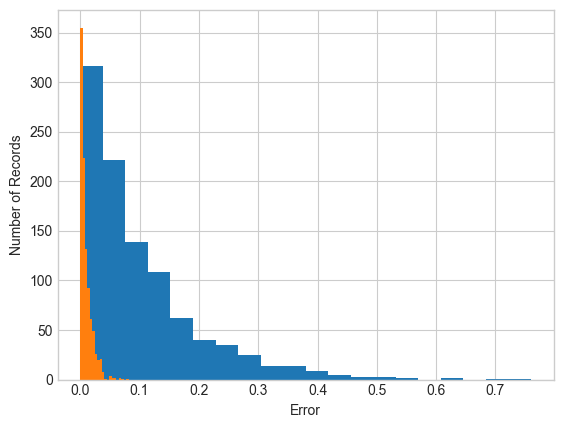

In [100]:
def graph_error1(epsilon):
    data=[]
    orig=query1()
    for i in range(1000):
        priv=dp_query1(epsilon)
        data.append(pct_error(orig, priv))
    plt.hist(data, bins=20)
        

graph_error1(0.1)
graph_error1(1.0)
plt.xlabel('Error')
plt.ylabel('Number of Records');

In [101]:
error_spec = 100.0 * np.abs(np.random.laplace(loc=0, scale=1, size=1000)) / query1()

with patch('matplotlib.pyplot.hist') as mock_hist:
    graph_error1(1.0)
    
args, kwargs = mock_hist.call_args
assert stats.wasserstein_distance(error_spec, args[0]) < 0.001

## Question 2 (e)

In 2-5 sentences, answer the following:

- How does the histogram of relative errors for $\epsilon = 0.1$ differ from the one for $\epsilon = 1.0$?
- What do the two histograms tell you about the effect of $\epsilon$ on relative error?

Both histograms follow the same shape (corresponding to the laplace distribution, which makes sense) but the histogram for epsilon=1.0 has bins covering a much smaller range since there is a lower maximum percentage error. Comparing the two histograms I can see that a larger epsilon corresponds to less percentage error.

## Question 2 (f)

Consider `query2`, which asks how many people in the dataset are over the age of 60.

In [102]:
def query2():
    return len(adult[adult['Age'] > 60])

query2()

1806

Implement `dp_query2`, a differentially private version of `query2` (as in Question 2 (c)), and `graph_error2`, which graphs relative error for `dp_query2` (as in question 4).

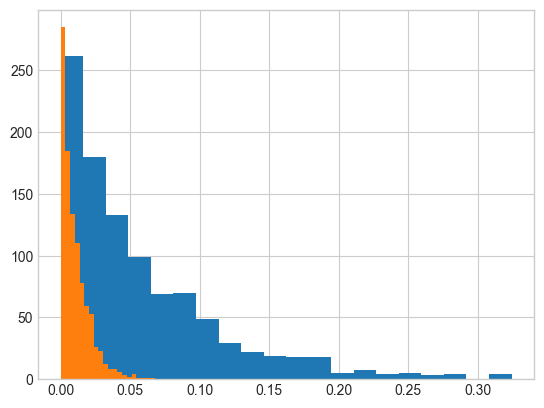

In [103]:
def dp_query2(epsilon):
    return query2() + np.random.laplace(loc=0, scale=1/epsilon)

def graph_error2(epsilon):
    data=[]
    orig=query2()
    for i in range(1000):
        priv=dp_query2(epsilon)
        data.append(pct_error(orig, priv))
    plt.hist(data, bins=20)

graph_error2(1.0)
graph_error1(1.0) # we plot both errors for query 1 and query 2 at the same epsilon, to compare

In [104]:
error_spec = 100.0 * np.abs(np.random.laplace(loc=0, scale=1, size=1000)) / query2()

with patch('matplotlib.pyplot.hist') as mock_hist:
    graph_error2(1.0)
    
args, kwargs = mock_hist.call_args
assert stats.wasserstein_distance(error_spec, args[0]) < 0.01

## Question 2 (g) 

In 2-5 sentences, answer the following:

- Given the graph from question 6, how does relative error differ between `dp_query1` and `dp_query2` for the same value of $\epsilon$?
- What property of the query causes the difference in relative errors between `dp_query1` and `dp_query2`?

For the same value of epsilon dp_query1 shows much less relative error than dp_query2. This is because dp_query1 has a much larger output (close to 10000) compared with dp_query2 (about 2000), therefore with the same noise added the ratio changes less and there is less error. 